In [1]:
from matplotlib import pyplot as plt
import numpy as np
import random
import time
import math

In [2]:
class Individual:
    def __init__(self, functions, lb, ub):
        self.functions = functions
        self.lb = lb
        self.ub = ub
        self.code = np.random.random(len(lb)) * (ub - lb) + lb
        self.fvalue = np.empty(len(functions))
        self.evaluate()
        
        self.rank = math.inf
        self.crowding_distance = float('inf')

    def evaluate(self):
        for i in range(len(self.functions)):
            self.fvalue[i] = self.functions[i](self.code)

    def __str__(self):
        return self.code

In [3]:
# Function to find Pareto front

def find_pareto_front(population):
    pop_size = len(population)
    fNum = len(population[0].functions)
    pareto_front = []
    pareto_front_ids = []
    
    for i in range(pop_size):
        is_pareto_optimal = True

        for j in range(pop_size):
            if i != j:
                is_dominated = True
                for k in range(fNum):
                    is_dominated &= population[i].fvalue[k] > population[j].fvalue[k]
                if is_dominated:
                    is_pareto_optimal = False
                    break
        if is_pareto_optimal:
            pareto_front.append(population[i])
            pareto_front_ids.append(i)

    return pareto_front_ids, pareto_front

In [4]:
# Non-dominated sorting algorithm

def non_dominated_sort(population, max_fronts):
    removable_population = np.array(population.copy())
    pareto_fronts = []
    rank = 1

    for i in range(max_fronts):
        if len(removable_population) == 0:
            break
        pareto_front_ids, pareto_front = find_pareto_front(removable_population)
        pareto_fronts.append(pareto_front)
        for individual in pareto_front:
            individual.rank = rank
        removable_population = np.delete(removable_population, pareto_front_ids)
        rank += 1
    return pareto_fronts

In [5]:
# Calculating crowding distances for elements of the same Pareto front

def calculate_crowding_distance(front):
    fNum = len(front[0].functions)
    crowding_distances = np.zeros(len(front))
    
    for k in range(fNum):
        front.sort(key = lambda x: x.fvalue[k])

        crowding_distances[0] = float('inf')
        crowding_distances[-1] = float('inf')

        min_fvalue = front[0].fvalue[k]
        max_fvalue = front[-1].fvalue[k]

        if max_fvalue == min_fvalue:
            continue

        for i in range(1, len(front) - 1):
            crowding_distances[i] += (front[i+1].fvalue[k] - front[i-1].fvalue[k]) / (max_fvalue - min_fvalue)

    for i in range(len(front)):
        front[i].crowding_distance = crowding_distances[i]

In [6]:
# Tournament selection, picking a random member of the tournaments Pareto front

def selection(population, tournament_size):
    chosen = random.sample(population, tournament_size)

    return min(chosen, key = lambda x: (x.rank, -x.crowding_distance))

In [7]:
# Whole arithmetic recombination

def crossover(parent1, parent2, child1, child2, alpha = 0.5):
    for i in range(len(child1.code)):
        child1.code[i] = parent1.code[i] * alpha + parent2.code[i] * (1 - alpha)
        child2.code[i] = parent2.code[i] * alpha + parent1.code[i] * (1 - alpha)

In [8]:
# Uniform mutation

def mutation(individual, mutation_prob):
    for i in range(len(individual.code)):
        if np.random.random() < mutation_prob:
            individual.code[i] = np.random.random() * (individual.ub[i] - individual.lb[i]) + individual.lb[i]

In [32]:
def nsga(functions, lb, ub, pop_size, num_generations, max_fronts, tournament_size, crossover_alpha, mutation_prob, showGraph = True):
    start_time = time.time()
    
    # Initializing population
    population = [Individual(functions, lb, ub) for _ in range(pop_size)]
    new_population = population.copy()

    for i in range(num_generations):
        # Calculating pareto front layer level/rank
        pareto_fronts = non_dominated_sort(population, max_fronts)

        # Calculating crowding distances
        for front in pareto_fronts:
            calculate_crowding_distance(front)
        
        for j in range(0, pop_size, 2):
            # Selecting "optimal" parents for crossover
            parent1 = selection(population, tournament_size)
            parent2 = selection(population, tournament_size)

            # Crossing-over the parent code into children
            crossover(parent1, parent2, child1=new_population[j], child2=new_population[j+1], alpha=crossover_alpha)

            # Mutating the children
            mutation(new_population[j], mutation_prob)
            mutation(new_population[j+1], mutation_prob)

            # Calculating the children's function value/fitness
            new_population[j].evaluate()
            new_population[j+1].evaluate()

        # Implicit elitism
        joined = population + new_population
        
        pareto_fronts = non_dominated_sort(joined, 2*max_fronts)
        for front in pareto_fronts:
            calculate_crowding_distance(front)
            
        joined.sort(key = lambda x: (x.rank, -x.crowding_distance))
        
        population = joined[:pop_size].copy()

    # Finding pareto front of the final population
    _, pareto_front = find_pareto_front(population)

    print("Found Pareto front elements:", len(pareto_front))
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Elapsed time:", elapsed_time, "seconds")
    # Plotting results
    fNum = len(population[0].functions)
    if fNum == 2:
        plt.xlabel('f1(x)')
        plt.ylabel('f2(x)')
        if showGraph:
            plt.scatter([x.fvalue[0] for x in population], [y.fvalue[1] for y in population])
        plt.scatter([x.fvalue[0] for x in pareto_front], [y.fvalue[1] for y in pareto_front], label = 'pareto_front')
        plt.legend()
    elif fNum == 3:
        ax = plt.figure().add_subplot(projection='3d')
        ax.set_xlabel('f1(x)')
        ax.set_ylabel('f2(x)')
        ax.set_zlabel('f3(x)')
        if showGraph:
            ax.scatter([x.fvalue[0] for x in population], [y.fvalue[1] for y in population], [z.fvalue[2] for z in population])
        ax.scatter([x.fvalue[0] for x in pareto_front], [y.fvalue[1] for y in pareto_front], [z.fvalue[2] for z in pareto_front], label = 'pareto_front')
        ax.legend()
    else:
        print("Too many dimensions to plot!")

Found Pareto front elements: 100
Elapsed time: 8.233064651489258 seconds


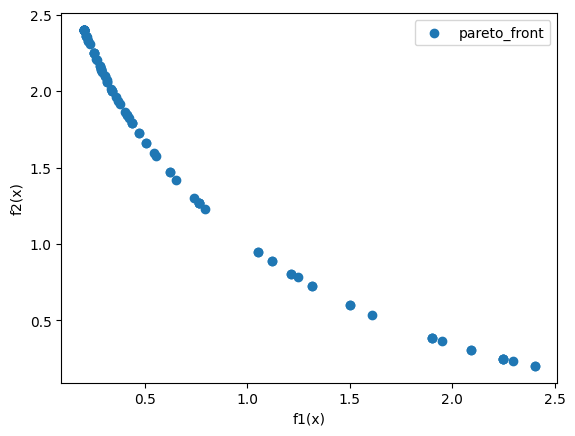

In [33]:
# Schaffer function N.1
# -A <= X <= A, where A is between 10 and 10e5, higher A's increasing the difficulty of the problem

def f1(x):
    return x[0]**2

def f2(x):
    return (x[0]-2)**2

A = 10
lower_bounds = np.array([-A])
upper_bounds = np.array([A])

nsga(functions=[f1,f2], lb=lower_bounds, ub=upper_bounds, pop_size=100, num_generations=100, max_fronts = 1000, tournament_size=5, crossover_alpha=0.3, mutation_prob=0.05, showGraph = False)

Found Pareto front elements: 100
Elapsed time: 8.066254615783691 seconds


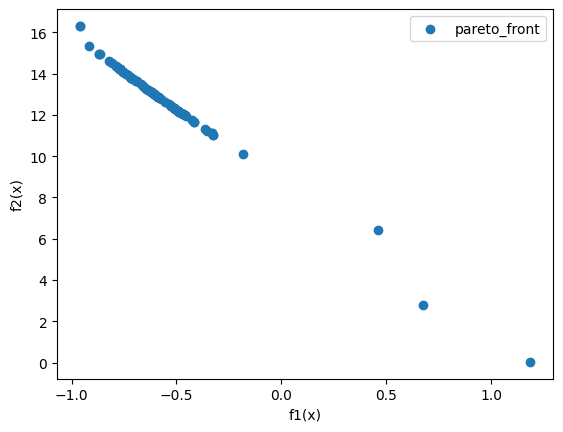

In [34]:
# Schaffer function N.2
# -5 <= x <= 10

def f1(x):
    if x[0] <= 1:
        return -x[0]
    elif x[0] <= 3:
        return x[0] - 2
    elif x[0] <= 4:
        return 4 - x[0]
    else:
        return x[0] - 4
        
def f2(x):
    return (x[0] - 5)**2

lower_bounds = np.array([-5])
upper_bounds = np.array([10])

nsga(functions=[f1,f2], lb=lower_bounds, ub=upper_bounds, pop_size=100, num_generations=100, max_fronts = 100, tournament_size=5, crossover_alpha=0.3, mutation_prob=0.05, showGraph = False)

Found Pareto front elements: 100
Elapsed time: 7.928609609603882 seconds


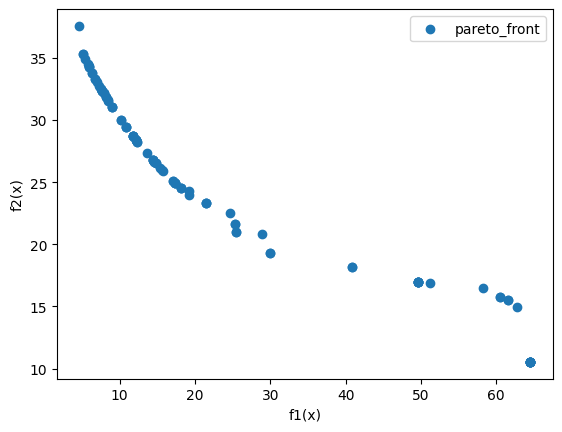

In [35]:
# Bihn and Korn function without constraints
# 0 <= x <= 5
# 0 <= y <= 3

def f1(x):
    return 4*(x[0]**2 + x[1]**2)

def f2(x):
    return (x[0]-5)**2 + (x[1]-5)**2

lower_bounds = np.array([0, 0])
upper_bounds = np.array([5, 3])

nsga(functions=[f1,f2], lb=lower_bounds, ub=upper_bounds, pop_size=100, num_generations=100, max_fronts = 1000, tournament_size=5, crossover_alpha=0.3, mutation_prob=0.05, showGraph = False)

Found Pareto front elements: 100
Elapsed time: 9.031885623931885 seconds


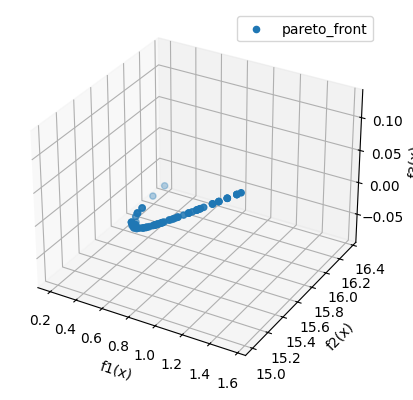

In [36]:
# Viennet function
# -3 <= x,y <= 3

def f1(x):
    return 0.5*(x[0]**2 + x[1]**2) + np.sin(x[0]**2 + x[1]**2)

def f2(x):
    return ((3*x[0] - 2*x[1] + 4)**2)/8 + ((x[0] - x[1] + 1)**2)/27 + 15

def f3(x):
    return 1/(x[0]**2 + x[1]**2 + 1) - 1.1*np.exp(-(x[0]**2+x[1]**2))

lower_bounds = np.array([-3, -3])
upper_bounds = np.array([3, 3])

nsga(functions=[f1,f2,f3], lb=lower_bounds, ub=upper_bounds, pop_size=100, num_generations=100, max_fronts = 1000, tournament_size=5, crossover_alpha=0.3, mutation_prob=0.05, showGraph = False)